In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import Binarizer

import warnings
warnings.filterwarnings(action='ignore')

sns.set()

In [2]:
def my_eval(y_val, pred, proba, th):  #avg='binary'
        accuracy = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred)
        recall = recall_score(y_val, pred)
        f1 = f1_score(y_val, pred)
        matrix = confusion_matrix(y_val, pred)
        print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
        print("오차행렬\n", matrix)
        # cls_report = classification_report(y_val, pred)

        # --------------- 양성 평가를 위한 차트 : precision_recall_curv() -------------------    
        # plot_precision_recall_curve(model, 문제지2, 정답지2)
        precisions, recalls, ths = precision_recall_curve(y_val, proba[:, 1])
        plt.title("precision recall curv %0.2f %0.4f"%(th,f1))
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("threadhold")
        plt.ylabel("value")
        plt.plot(ths, precisions[:ths.shape[0]], "b", label="precision")
        plt.plot(ths, recalls[:ths.shape[0]], "r", linestyle='--', label="recall")
        plt.grid()
        plt.legend()
        plt.show()
        
        
        # --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
        auc_score = roc_auc_score(y_val, proba[:, 1])

        fprs, tprs, ths = roc_curve(y_val, proba[:, 1])
        plt.title("roc curv %0.4f" % auc_score)
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("FPR(1-specificity)")
        plt.ylabel("TPR")
        plt.grid()
        plt.plot(fprs, tprs, "b")
        plt.plot([0, 1], [0, 1], '--', color='black')
        plt.show()


def split_fit_score(X, y, model=None, test_size=0.2, th_list=None):

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,random_state=1414,shuffle=False)

        model.fit(X_train, y_train)
        pred = model.predict(X_test)                                        #[0  1]              th:0.5
        proba = model.predict_proba(X_test)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
        
        # ------------------ proba : 양성 점수 측정을 위한 예측 확률값 ---------------
        # proba 리턴값 : ndarray of shape (n_samples, n_classes)  150*3
        # [
        #     [0.4 0.6]  --> 1
        #     [0.7 0.3]  --> 0
        #     [0.42 0.58] -> 1
        # ]
        
        if th_list == None:
            #------------------방법1 ) 임계치 0.5(기본값)으로 점수 출력 ---------------
            binz = Binarizer(threshold=0.5)                              # th:0.5
            pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))    # [[.7 >.3] [.4  <.6]]  --> [0  1]
            my_eval(y_test, pred_binz, proba, 0.5)                        # 점수def호출
 
        else:
            # ----------------방법2) 임계치 조정해가면서 최적의 점수 찾기---------------
            # (24 양성인데 틀리게예측) --> 임계치 낮춘다 == 양성학습데이터늘린다  == 양성점수를 올린다 
            th_list = [0, 0.35 , 0.38, 0.42, 0.45, 0.5, 1]
            for th in th_list:
                    binz = Binarizer(threshold=th)                              # [[.7 .3] [.4  .6]]   th:0.2
                    pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))   # [  th<.3] [  th<.6]]  --> [1 1]
                    print(th)
                    my_eval(y_test, pred_binz, proba, th)                       #점수def호출

## 데이터 로드
<pre>
'id': 등록자 ID
'city': 지역코드
'city_development_index': 지역개발지수
'gender': 성별
'relevent_experience': 관련경험
'enrolled_university': 대학과정
'education_level': 교육수준
'major_discipline': 전공
'experience':경력(년)
'company_size': 소속회사 직원수
'company_type': 소속회사 유형
'last_new_job': 현재 직업 경력(년)
'training_hours': 교육 이수 시간
'target': 목표변수, 다른 일을 찾는 경우1, 아니면 0
</pre>

In [3]:
df = pd.read_csv("kote_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
df.shape  #(19158, 14)

(19158, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

## EDA

1. target 확인

In [6]:
df['target'].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

2.결측확인
* 결측이 있는 피쳐만 상단으로 출력
* 결측이 있는 피쳐만 출력

In [7]:
df.isna().sum().sort_values(ascending=False)

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
target                       0
dtype: int64

In [8]:
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False) #.index


company_type           6140
company_size           5938
gender                 4508
major_discipline       2813
education_level         460
last_new_job            423
enrolled_university     386
experience               65
dtype: int64

In [9]:
nan_df = pd.DataFrame({"CNT":df.isna().sum(), "RATE":  df.isna().sum()/df.shape[0]*100   })
nan_df.sort_values('CNT', ascending=False) #.T

,CNT,RATE
company_type,6140,32.049274
company_size,5938,30.994885
gender,4508,23.530640
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
experience,65,0.339284
enrollee_id,0,0.000000
city,0,0.000000


3. Object 타입 피쳐 출력
* https://stackoverflow.com/questions/29245848/what-are-all-the-dtypes-that-pandas-recognizes?rq=1
* https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes

In [10]:
# df.dtypes[df.dtypes=='object'].index
obj_cols = df.dtypes[df.dtypes=='object'].index
print(obj_cols)

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')


## 가공처리

1. 결측처리
* ['company_type', 'company_size', 'gender', 'major_discipline', 'education_level', 'last_new_job', 'enrolled_university', 'experience']

In [11]:
nan_cols = ['company_type', 'company_size', 'gender', 'major_discipline', 'education_level', 'last_new_job', 'enrolled_university', 'experience']

In [12]:
for col in nan_cols:
    print(df[col].value_counts())
    print("--"*20)

Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64
----------------------------------------
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64
----------------------------------------
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
----------------------------------------
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64
----------------------------------------
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64
----------------------------------------

####  company_size 구간화
<pre>
<10          1308
10/49        1471
50-99        3083
100-500      2571
500-999       877
1000-4999    1328
5000-9999     563
10000+       2019
</pre>

In [13]:
dict = {'<10':1, '10/49':2, '50-99':3, '100-500':4, '500-999':5, '1000-4999':6, '5000-9999':7, '10000+':8}
df['company_size2'] = df['company_size'].map(dict)
df[['company_size','company_size2']].head()

,company_size,company_size2
0,NaN,NaN
1,50-99,3.0
2,NaN,NaN
3,NaN,NaN
4,50-99,3.0


In [14]:
df['company_size2'].describe()

count    13220.000000
mean         4.253328
std          2.190880
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          8.000000
Name: company_size2, dtype: float64

<AxesSubplot:xlabel='company_size2', ylabel='count'>

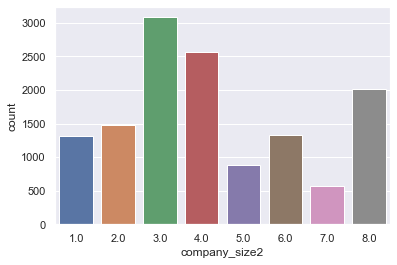

In [15]:
# df['company_size2'].hist()
sns.countplot('company_size2',data=df)

#### company_type

In [16]:
dict = {'Pvt Ltd':1,'Funded Startup':2,'Public Sector':3,'Early Stage Startup':4,'NGO':5,'Other':6}
df['company_type2'] = df['company_type'].map(dict)
df[['company_type','company_type2']].head()

,company_type,company_type2
0,NaN,NaN
1,Pvt Ltd,1.0
2,NaN,NaN
3,Pvt Ltd,1.0
4,Funded Startup,2.0


In [17]:
df['company_type2'].describe()

count    13018.000000
mean         1.569135
std          1.155907
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: company_type2, dtype: float64

<AxesSubplot:xlabel='company_type2', ylabel='count'>

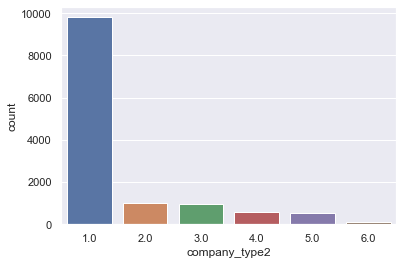

In [18]:
sns.countplot('company_type2',data=df)

#### company_type2 별 company_size2 평균

In [19]:
# df.groupby("company_type2")
# df['company_size2'].mean()
df.groupby("company_type2")['company_size2'].mean()

company_type2
1.0    4.498459
2.0    2.840201
3.0    5.146489
4.0    1.805000
5.0    4.341414
6.0    4.371681
Name: company_size2, dtype: float64

* company_type2 결측처리 : 최빈도 1값으로 처리 

* company_size2 결측처리  : company_type2 그룹별 company_size2 평균값

In [20]:
# df[['company_type2','company_size2']] = df[['company_type2','company_size2']].fillna( 0)
df['company_type2'].mode()

df['company_type2'] = df['company_type2'].fillna(1)
df['company_size2'] = df['company_size2'].fillna( df.groupby("company_type2")['company_size2'].transform('mean') )


In [21]:
df[['company_type2','company_size2']].isna().sum()

company_type2    0
company_size2    0
dtype: int64

### pd.get_dummies() 소개

In [22]:
# ## 결측처리(0,'')  + LabelEncoding() + OneHotEncoding()
# df22 = pd.get_dummies(df[['gender','education_level']])
# print(df22.info())
# df22.head()

### LabelEncoder() 소개

In [23]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# data = ["f", "m","o", np.nan]
# res_encoder = encoder.fit_transform(data)
# print(res_encoder)  #[0 1 2]
# original_data = encoder.inverse_transform(res_encoder)
# print(original_data)

### gender 결측처리 : 최빈도 (Male) 값

<AxesSubplot:>

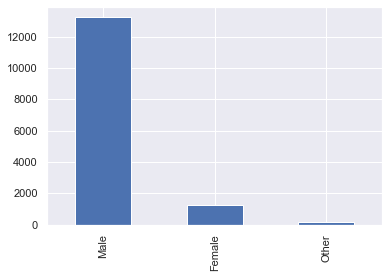

In [24]:
df['gender'].value_counts().plot(kind='bar')

In [25]:
df['gender'] = df['gender'].fillna('Male')
df['gender'].isna().sum()

0

In [26]:
df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

## 상관분석
* 두 피쳐간의 선형관계 (-1.0~1.0)
  + - 0.3~ 0.7: 강한상관
  + - 0.7~ 1.0: 매우~~ 강한상관(0.8이상 다중공선)
* 다중공선성 해결방법 : drop, PCA(차원축소)

<AxesSubplot:>

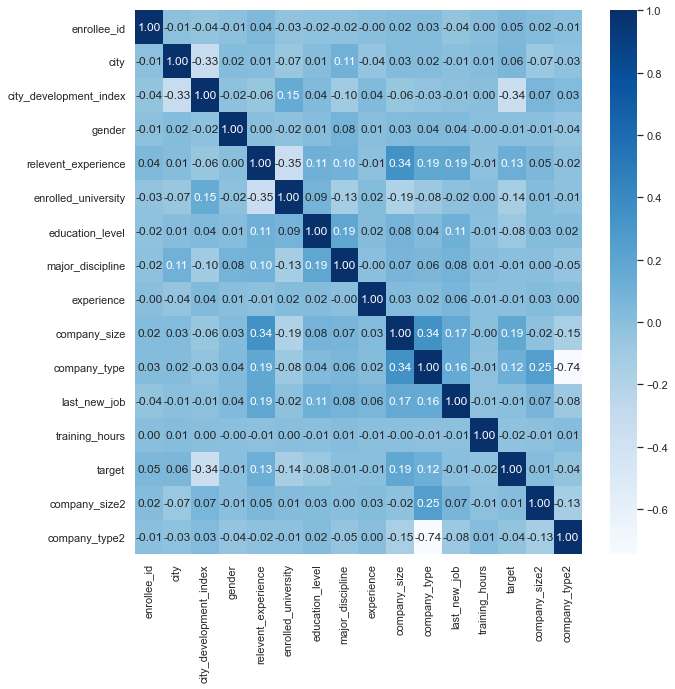

In [27]:
df2 = df.copy()
for col in obj_cols:
    encoder = LabelEncoder()
    df2[col] = encoder.fit_transform(df2[col])

fig, ax = plt.subplots(figsize=(10,10))     
sns.heatmap(df2.corr(), annot=True, fmt=".2f", cmap="Blues")

* enrolled_university - relevenet_experience  : -.35 (약 음 상관관계)
* company_type - company_size  : .34 (약 양 상관관계)
* relevent_experience - company_size : 0.34 (약 양 상관관계)

In [28]:
print(df2.corr().nlargest(5, 'target').index)
print(df2.corr().nsmallest(5, 'target').index)    

Index(['target', 'company_size', 'relevent_experience', 'company_type',
       'city'],
      dtype='object')
Index(['city_development_index', 'enrolled_university', 'education_level',
       'company_type2', 'training_hours'],
      dtype='object')


#### 'enrolled_university': 대학과정  'relevent_experience': 관련경험

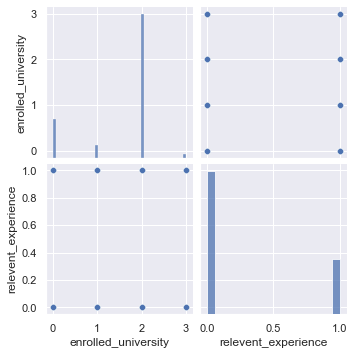

In [29]:
sns.pairplot(df2[['enrolled_university','relevent_experience']])

In [30]:
for col in nan_cols : 
    print(col , df[col].unique().tolist())  #'Male', nan, 'Female', 'Other'
    print("--"*20)
    print(df[col].value_counts())
    print("--"*20)

# 수치형 변환 시 레벨 유지 불필요 --> 원핫인코딩 -------------------------    
# gender ['Male', nan, 'Female', 'Other']
# major_discipline ['STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other']

# 수치형 변환 시 레벨 유지해야 할 피쳐 -----------------------------------
# education_level ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd', nan  ]
# enrolled_university ['no_enrollment', 'Full time course', nan, 'Part time course']
# last_new_job ['1', '>4', 'never', '4', '3', '2', nan]
# experience ['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4', '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan]

company_type [nan, 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO']
----------------------------------------
Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64
----------------------------------------
company_size [nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49', '100-500', '500-999']
----------------------------------------
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64
----------------------------------------
gender ['Male', 'Female', 'Other']
----------------------------------------
Male      17729
Female     1238
Other       191
Name: gender, dtype: int64
----------------------------------------
major_discipline ['STEM', 'Business Degree', nan, 'Arts', 'H

## 결측처리  : 최빈도 값으로 채우기
<pre>
company_type : Pvt Ltd 
company_size : company_type 그룹별 평균
gender  : 'Male'
major_discipline : 'STEM'
education_level : 'Graduate'
last_new_job : '1'
enrolled_university : 'no_enrollment'
experience: '>20'  
</pre>

In [31]:
for col in nan_cols : 
    df[col].fillna(df[col].mode()[0], inplace=True)    

### 문자형 --> 수치형 변환 (LabelEncoding)

In [32]:
for col in obj_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int32  
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  int32  
 4   relevent_experience     19158 non-null  int32  
 5   enrolled_university     19158 non-null  int32  
 6   education_level         19158 non-null  int32  
 7   major_discipline        19158 non-null  int32  
 8   experience              19158 non-null  int32  
 9   company_size            19158 non-null  int32  
 10  company_type            19158 non-null  int32  
 11  last_new_job            19158 non-null  int32  
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
 14  company_size2           19158 non-null

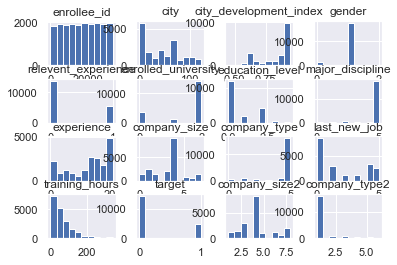

In [34]:
df.hist()
plt.show()

In [35]:
df['gender'].unique()

array([1, 0, 2])

#### 가공이 끝난 피쳐 삭제

In [36]:
del_cols = ['enrollee_id', 'company_type','company_size']
df = df.drop(del_cols, axis=1)

In [37]:
df.shape

(19158, 13)

In [38]:
# df = pd.get_dummies(df, columns=['gender','major_discipline'], drop_first=True)

In [39]:
df.shape

(19158, 13)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  int32  
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  int32  
 3   relevent_experience     19158 non-null  int32  
 4   enrolled_university     19158 non-null  int32  
 5   education_level         19158 non-null  int32  
 6   major_discipline        19158 non-null  int32  
 7   experience              19158 non-null  int32  
 8   last_new_job            19158 non-null  int32  
 9   training_hours          19158 non-null  int64  
 10  target                  19158 non-null  float64
 11  company_size2           19158 non-null  float64
 12  company_type2           19158 non-null  float64
dtypes: float64(4), int32(8), int64(1)
memory usage: 1.3 MB


In [41]:
df[['target','company_type2']] = df[['target','company_type2']].astype('int')
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target,company_size2,company_type2
0,5,0.920,1,0,2,0,5,21,0,36,1,4.457462,1
1,77,0.776,1,1,2,0,5,6,4,47,0,3.000000,1
2,64,0.624,1,1,0,0,5,15,5,83,0,4.457462,1
3,14,0.789,1,1,2,0,1,20,5,52,1,4.457462,1
4,50,0.767,1,0,2,2,5,21,3,8,0,3.000000,2


## 분석모델

In [42]:
y = df['target']
X = df.drop('target', axis=1)
model = RandomForestClassifier(n_estimators=300,random_state=1414) 
# model = DecisionTreeClassifier() 

정확도0.7790 정밀도:0.5629 재현률:0.4426 f1:0.4955
오차행렬
 [[2569  323]
 [ 524  416]]


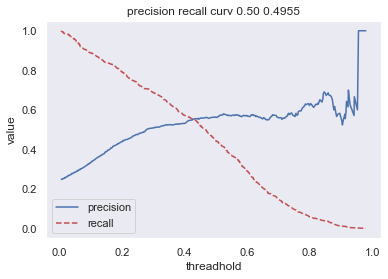

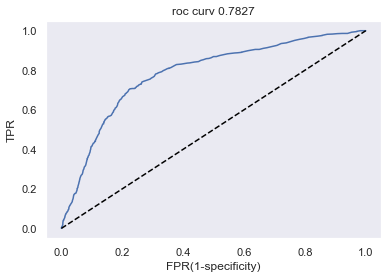

In [43]:
split_fit_score(X, y, model)   #0.4955